# Individual Level Epidemic Models

Susceptible-Infected-Removed (SIR) models make up the core of stochastic epidemic modeling. The simplest case of the model proposes that an population (of size $N$) transitions through three stages. Individuals start in the susceptible stage (unless they are part of the initial infected subset). As a result of interacting with the infected individuals in a population, a susceptible member transitions to the infected stage at a rate $\beta(\cdot)$ which is a function of some covariates. Once infected, these members of the population contribute to the total infectious pressure, infecting other susceptibles or they become removed (recovered - and assumed to be immune, or die) at a rate $\gamma(\cdot)$ which is a function of some covariates.

In this document, we look at performing Bayesian inference on these models with the goal of *correctly* estimating the parameters of the rate functions $(\beta(\cdot), \gamma(\cdot))$. We will be using the 1861 Hagelloch measles data set for this exercise and augment it as necessary.

In [2]:
# preamble - load all packages 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime

from scipy import stats
from sklearn.metrics.pairwise import euclidean_distances

sns.set()

In [3]:
measles = pd.read_csv('measles_hagelloch_1861.csv')

In [4]:
pairwise_distances = euclidean_distances(X=measles[['x_loc', 'y_loc']])

In [5]:
# formating the dates 
measles['date_of_prodrome'] = pd.to_datetime(measles['date_of_prodrome'], format='%Y-%m-%d')
measles['date_of_rash'] = pd.to_datetime(measles['date_of_rash'], format='%Y-%m-%d')
measles['date_of_death'] = pd.to_datetime(measles['date_of_death'], format='%Y-%m-%d')

In [6]:
# fill death time - death is NaN in many cases 
measles['date_of_death'] = measles['date_of_death'].fillna(pd.to_datetime('1/1/2000'))

In [7]:
# to avoid imputing removal time, assume rash + 5 days
measles = measles.assign(
    date_of_removal=lambda df: df.date_of_rash + datetime.timedelta(days=5))
measles = measles.assign(date_of_removal=measles[['date_of_removal', 'date_of_death']].min(axis=1))

In [8]:
# preview the data
measles.head()

,case_ID,infector,date_of_prodrome,date_of_rash,date_of_death,age,gender,family_ID,class,complications,x_loc,y_loc,date_of_removal
0,1,45.0,1861-11-21,1861-11-25,2000-01-01,7,f,41,1,yes,142.5,100.0,1861-11-30
1,2,45.0,1861-11-23,1861-11-27,2000-01-01,6,f,41,1,yes,142.5,100.0,1861-12-02
2,3,172.0,1861-11-28,1861-12-02,2000-01-01,4,f,41,0,yes,142.5,100.0,1861-12-07
3,4,180.0,1861-11-27,1861-11-28,2000-01-01,13,m,61,2,yes,165.0,102.5,1861-12-03
4,5,45.0,1861-11-22,1861-11-27,2000-01-01,8,f,42,1,yes,145.0,120.0,1861-12-02


The above dataset is a complete epidemic dataset since the dates for each individuals transition through the S-I-R model are recorded. With the model propsed by Neal & Roberts, some data augmentation is needed. The full likelihood of the model is as follows: 

$$f(I,R | \beta, \theta, Z, P, I_k) = \prod_{j \neq k} \left\{ \sum_{i \in I_j} \beta \exp \{ -\theta \kappa(i,j) \} \right\} \exp \left\{ \sum_{j=1}^m \sum_{k=1}^n \lambda_{jk} \{ \min(R_j, I_k) - \min(I_j, I_k ) \} \right\} \prod_{i=1}^m g(S_i - I_i) $$ 
For simplicty, the infectious pressure will be restricted to a spatial component such that $ \lambda_{ij} =  \beta \exp \{ -\theta \kappa(i,j) \} $.
$$ $$
\begin{equation}
    \log f(I,R | \beta, \theta, Z, P, I_k) = \sum_{j \neq k} \log \left( \sum_{i:I_i \leq I_j \leq R_i }   \beta \exp \{ -\theta \kappa(i,j) \right) - \sum_{j=1}^m \sum_{k=1}^n  \beta \exp \{ -\theta \kappa(j,k)\} \{ \min(R_j, I_k) - \min(I_j, I_k ) \} + \sum_{i=1}^m \log f(D_i|\delta)
\end{equation} 

However, since we set the recovery to 5 days, we not longer need to assume those days come from a gamma distribution. The last term in the log-likelihood $\sum_{i=1}^m \log f(D_i|\delta)$ is now just $\sum_{i=1}^m \min \{\text{recovery}_i, \text{death}_i \}$ (regardless of the resulting min, it is a constant w.r.t the parameters and can be dropped).

\begin{equation}
    \log f(I,R | \beta, \theta, Z, P, I_k) \propto \sum_{j \neq k} \log \left( \beta \sum_{i:I_i \leq I_j \leq R_i }  \exp \{ -\theta \kappa(i,j) \right) - \sum_{j=1}^m \sum_{k=1}^n  \beta \exp \{ -\theta \kappa(j,k)\} \left[ \min(R_j, I_k) - \min(I_j, I_k ) \right]
\end{equation}

In [9]:
# compute min(I_j, I_k )
pairwise_infections = np.fmin(np.array(measles.date_of_prodrome)[
                              :, None], np.array(measles.date_of_prodrome)[None, :])

# compute min(R_j, I_k)
pairwise_infection_removal = np.fmin(np.array(measles.date_of_prodrome)[
                                      :, None], np.array(measles.date_of_death)[None, :])

# compute infectious overlap period 
pairwise_infectious_overlap = (pairwise_infection_removal - pairwise_infections) / np.timedelta64(1, "D")
# compute the WAIFW matrix
WAIFW = np.float64(pairwise_infectious_overlap > 1)

## MCMC Algorithm 

In [35]:
# try to back out the overall event rate in the population: i.e. run MCMC for an exponential distribution
def ILMepidemic_MCMC(data, init, iters=10001):

    def metropolisHastings(init, logLik, rprop, dprior, iters=iters):
        # initialize matrix to store results
        mat = np.zeros(shape=(iters, len(init)))
        mat[0, :] = init

        theta = init

        # compute initial logLik
        ll_main = logLik(mat[0, :])

        # run the MCMC for iters many iterations

        for ii in range(iters):
            # propose new parameters
            theta_proposed = rprop(theta)
            # check if proposal is a valid one

            ll_proposed = logLik(theta_proposed)

            # compute the (log) acceptance probability

            a = ll_proposed-ll_main + \
                dprior(theta_proposed) - dprior(theta)
            # print(f"proposal, {theta_proposed}. alpha {a}.")

            if (np.log(stats.uniform(0, 1).rvs()) < a):
                # print('accept')
                theta = theta_proposed
                ll_main = ll_proposed

                # store the result
                mat[ii, :] = theta
            else:
                # print('reject')
                mat[ii, :] = mat[ii-1, :]

        print('MCMC done!')

        return mat

    # parameters are [beta, theta]
    def proposal_denisty(parameters):
        return stats.norm(parameters, 0.1).rvs()

    def prior_density(parameters):
        # np.sum(stats.gamma.logpdf(parameters, 3, loc=0, scale=1))
        return np.sum(stats.expon.logpdf(x=parameters[0], scale=0.1) + stats.expon.logpdf(x=parameters[1], scale=10))

    def logLik(parameters):
        part1 = (parameters[0] * WAIFW *
                 np.exp(- parameters[1] * pairwise_distances))
        part1 = np.sum(np.log(part1, where=(part1 != 0)))

        part2 = np.sum(parameters[0] * np.exp(- parameters[1]
                       * pairwise_distances) * pairwise_infectious_overlap)
        return part1 - part2

    ####################################################################################
    return metropolisHastings(init=init,
                              logLik=logLik,
                              rprop=proposal_denisty,
                              dprior=prior_density)


MCMC_results = ILMepidemic_MCMC(data=measles, init=[0.1, 0.1])

/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_26304/2197162004.py:55: RuntimeWarning: invalid value encountered in log
  part1 = np.sum(np.log(part1, where=(part1 != 0)))


MCMC done!


array([[<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

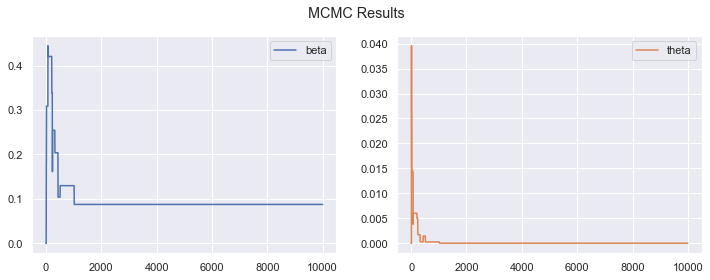

In [36]:
pd.DataFrame(MCMC_results, columns=['beta', 'theta']).loc[:,:].plot(
    title='MCMC Results',
    figsize=(12, 4),
    subplots=True,
    layout=(1, 2))

array([[<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>]],
      dtype=object)

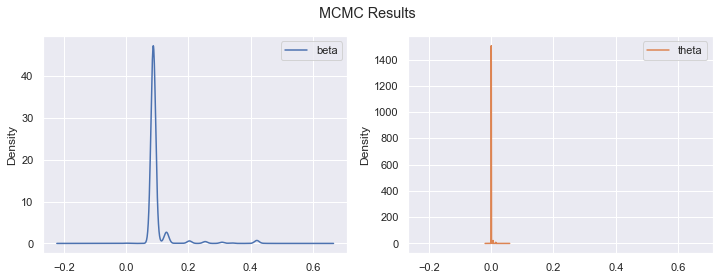

In [37]:
pd.DataFrame(MCMC_results, columns=['beta', 'theta']).plot(
    title='MCMC Results',
    kind = 'kde',
    figsize=(12, 4),
    subplots=True,
    layout=(1, 2))

In [38]:
pd.DataFrame(MCMC_results, columns=['beta', 'theta']).loc[100:,:].describe()

,beta,theta
count,9901.000000,9901.000000
mean,0.096975,0.000168
std,0.041979,0.000706
min,0.087670,0.000045
25%,0.087670,0.000045
50%,0.087670,0.000045
75%,0.087670,0.000045
max,0.420398,0.006029
